<a href="https://colab.research.google.com/github/rodolfoarruda/MachineLearning/blob/main/recom_sys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Rodolfo Arruda - 6381848

### **SCC5966 – Sistemas de Recomendação**

## **Setup**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
np.set_printoptions(suppress=True)

import pandas as pd
import matplotlib.pyplot as plt

# calculate sparsity
from numpy import array
from numpy import count_nonzero

# calculate similarity
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances

## **1 - Data Preparation**

In [78]:
df = pd.read_csv('/content/drive/MyDrive/Doutorado/disciplinas/recom_sys/scc5966/train_data.csv',sep=',')
df.head()

,user_id,movie_id,rating,timestamp
0,1,1160,5,974769817
1,1,1129,3,974769817
2,1,3328,4,974769817
3,1,2659,2,974769817
4,1,980,3,974769817


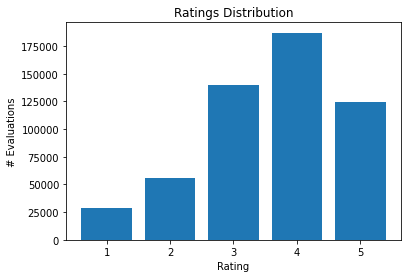

In [ ]:
plt.bar(df['rating'].value_counts().index,df['rating'].value_counts())
plt.title('Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('# Evaluations');

In [17]:
df['rating'].mean()

3.603814223642363

#### **1.1 - Dummy submission - by average movie**

In [ ]:
avg_movie = pd.DataFrame(df['rating'].groupby(df['movie_id']).mean())
avg_movie.reset_index(inplace=True)

In [ ]:
avg_movie.head()

,movie_id,rating
0,1,4.142373
1,2,3.214854
2,3,3.040000
3,4,2.666667
4,5,3.079137


In [83]:
df_test = pd.read_csv('/content/drive/MyDrive/Doutorado/disciplinas/recom_sys/scc5966/test_data.csv',sep=',')
df_test.head()

,id,user_id,movie_id,timestamp
0,0,5,2962,974769784
1,1,5,3177,974769768
2,2,5,3153,974769768
3,3,5,501,974769768
4,4,5,3159,974769768


In [ ]:
df_test.count()

id           3970
user_id      3970
movie_id     3970
timestamp    3970
dtype: int64

In [ ]:
pred_dummy_movie = pd.merge(df_test, avg_movie, on="movie_id",how="left").fillna(4)

In [ ]:
pred_dummy_movie.head()

,id,user_id,movie_id,timestamp,rating
0,0,5,2962,974769784,3.388000
1,1,5,3177,974769768,3.245223
2,2,5,3153,974769768,2.742857
3,3,5,501,974769768,3.615079
4,4,5,3159,974769768,2.987013


In [ ]:
pred = pred_dummy_movie[['id','rating']]
pred.head()

,id,rating
0,0,3.388000
1,1,3.245223
2,2,2.742857
3,3,3.615079
4,4,2.987013


In [ ]:
pred.to_csv('/content/drive/MyDrive/Doutorado/disciplinas/recom_sys/scc5966/s1.csv',index=False)

#### **1.2 - Dummy submission - by average user**

In [79]:
  avg_user= pd.DataFrame(df['rating'].groupby(df['user_id']).mean())
  avg_user.reset_index(inplace=True)

In [80]:
avg_user.head()

,user_id,rating
0,1,3.769231
1,2,3.428571
2,3,3.818182
3,4,4.375000
4,5,3.637931


In [84]:
pred_dummy_user = pd.merge(df_test, avg_user, on="user_id",how="left").fillna(3.603814223642363)

In [85]:
pred_dummy_user.count()

id           3970
user_id      3970
movie_id     3970
timestamp    3970
rating       3970
dtype: int64

In [86]:
pred = pred_dummy_user[['id','rating']]
pred.head()

,id,rating
0,0,3.637931
1,1,3.637931
2,2,3.637931
3,3,3.637931
4,4,3.637931


In [87]:
pred.to_csv('/content/drive/MyDrive/Doutorado/disciplinas/recom_sys/scc5966/s2.csv',index=False)

## **2 - Claborative Filtering based on movie**


In [63]:
df = pd.read_csv('/content/drive/MyDrive/Doutorado/disciplinas/recom_sys/scc5966/train_data.csv',sep=',')
df.head()

,user_id,movie_id,rating,timestamp
0,1,1160,5,974769817
1,1,1129,3,974769817
2,1,3328,4,974769817
3,1,2659,2,974769817
4,1,980,3,974769817


#### **2.1 - Data Normalization**

In [64]:
def sub_mean(df):
  ## Normalize rating by movie
  avg_movie = pd.DataFrame(df['rating'].groupby(df['movie_id']).mean())
  avg_movie = avg_movie.rename(columns = {'rating': 'avg_movie'})
  avg_movie.reset_index(inplace=True)
  result1 = pd.merge(df, avg_movie, on="movie_id")
  result1['rating_avgr_movie'] = result1['rating'] - result1['avg_movie']

  ## Normalize rating by user
  avg_user= pd.DataFrame(df['rating'].groupby(df['user_id']).mean())
  avg_user = avg_user.rename(columns = {'rating': 'avg_user'})
  avg_user.reset_index(inplace=True)
  result2 = pd.merge(result1, avg_user, on="user_id")
  result2['rating_avgr_user'] = result2['rating'] - result2['avg_user']

  return result2

In [65]:
df_norm = sub_mean(df)

In [66]:
df_norm.head()

,user_id,movie_id,rating,timestamp,avg_movie,rating_avgr_movie,avg_user,rating_avgr_user
0,1,1160,5,974769817,3.937198,1.062802,3.769231,1.230769
1,1,1129,3,974769817,3.993320,-0.993320,3.769231,-0.769231
2,1,3328,4,974769817,3.662202,0.337798,3.769231,0.230769
3,1,2659,2,974769817,3.688333,-1.688333,3.769231,-1.769231
4,1,980,3,974769817,3.927287,-0.927287,3.769231,-0.769231


#### **2.2 - user x item matrix**


In [67]:
A = df_norm.pivot(index='user_id', columns='movie_id', values='rating_avgr_movie').fillna(0)

In [68]:
A

movie_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,3525,3526,3527,3528,3529,3530,3531,3532,3533,3534,3535,3536,3537,3538,3539,3540,3541,3542,3543,3544,3545,3546,3547,3548,3549,3550,3551,3552,3553,3554,3555,3556,3557,3558,3559,3560,3561,3562,3563,3564
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.889023,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.804554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.714286,1.666667,0.069231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.700758,0.6,0.0,0.0,0.135135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


#### **2.3 - Sparcity evaluation**
##### The sparsity of a matrix can be quantified with a score, which is the number of zero values in the matrix divided by the total number of elements in the matrix.

In [69]:
sparsity = 1.0 - count_nonzero(A) /A.size
print(sparsity)

0.9620829658314144


##### A dense matrix stored in a NumPy array can be converted into a sparse matrix using the CSR representation by calling the csr_matrix() function.

In [70]:
from scipy import sparse

In [71]:
train = sparse.csr_matrix((df_norm.rating_avgr_movie, (df_norm.user_id, df_norm.movie_id)))

#### **2.4 - Compute similar movies**

##### A similarity matrix is critical to measure and calculate the similarity between user-profiles and movies to generate recommendations. To remove movie and user bias, we need to re-escale ratings base on average. 

In [72]:
similarity = cosine_similarity(train.T, dense_output = False)

In [73]:
print(similarity)

  (1, 2624)	0.01184259702579884
  (1, 643)	-0.02732228131674889
  (1, 3066)	0.006184594592036949
  (1, 2625)	0.0035153782505865827
  (1, 1943)	0.008373980663802008
  (1, 3518)	0.00014667022747913698
  (1, 1251)	-0.00040699336400194526
  (1, 3418)	-0.0029722592829170215
  (1, 1276)	0.0029722592829170215
  (1, 3134)	-0.005379848819375668
  (1, 2034)	-0.003405150787250603
  (1, 120)	0.0013901469876667362
  (1, 1338)	0.011891838805868306
  (1, 1355)	0.005409654304070885
  (1, 3439)	0.0010508523471976449
  (1, 763)	0.0024228072594061545
  (1, 1340)	0.02565115877524811
  (1, 3501)	-0.003405150787250603
  (1, 2551)	-0.030025857084566093
  (1, 416)	-0.003405150787250603
  (1, 2654)	-0.0005755755351674015
  (1, 3205)	-0.020511979742247683
  (1, 1953)	0.007822962126238644
  (1, 2381)	-0.00321040695017015
  (1, 3280)	0.003931929447300803
  :	:
  (3564, 2384)	0.004135695982481037
  (3564, 2363)	0.03019647607907639
  (3564, 2330)	0.05637301390101055
  (3564, 2308)	0.016544381536032108
  (3564, 2178

In [74]:
# Reference rating parameters
avg_movie = pd.DataFrame(df_norm['rating'].groupby(df_norm['movie_id']).mean())
avg_movie.reset_index(inplace=True)

# Reference movies
moviex=df_norm['movie_id'].unique()

In [ ]:
#moviex = [1160, 1129, 3328]

#### **2.5 - Compute top similar movies**

In [75]:
def sim_knearb(movie,k,similarity):
  y =pd.DataFrame(np.matrix(sparse.find(similarity)).T,columns=['similar','base','w'])
  z = y[y['base'] != y['similar']]

  return z[z['base'].isin([movie])].sort_values(by='w',ascending=False).head(k)

In [76]:
def avg_knearb(moviex,k,similarity):
  
  # auxiliar variables
  j = 0
  aux  = {'similar': [0.0], 'base': [0], 'w':[0.0]}
  base = pd.DataFrame(aux, columns = ['similar','base','w'])
 
  for i in moviex:
 
    top = sim_knearb(i , k , similarity)
    base = pd.concat([base, top])

    j += 1
    print('Iteração #:', j)
    
  #Merge
  #pred_movie = pd.merge(avg_movie,base, on="movie_id",how="inner")  
  #pred_movie['pond'] = pred_movie['w']*pred_movie['rating']
  
  
  return base

In [ ]:
base = avg_knearb(moviex,2,similarity)

In [ ]:
base.head()

In [ ]:
base.to_csv('/content/drive/MyDrive/Doutorado/disciplinas/recom_sys/scc5966/pto_checagem_sim2.csv',index=False)

#### **2.6 - Predictions**

In [9]:
base = pd.read_csv('/content/drive/MyDrive/Doutorado/disciplinas/recom_sys/scc5966/pto_checagem_sim4.csv')

In [10]:
base.head()

,similar,base,w
0,0.0,0.0,0.000000
1,1112.0,1160.0,0.293818
2,2368.0,1160.0,0.267087
3,2370.0,1160.0,0.214225
4,2373.0,1160.0,0.211034


In [7]:
df_norm.head()

,user_id,movie_id,rating,timestamp,avg_movie,rating_avgr_movie,avg_user,rating_avgr_user
0,1,1160,5,974769817,3.937198,1.062802,3.769231,1.230769
1,1,1129,3,974769817,3.993320,-0.993320,3.769231,-0.769231
2,1,3328,4,974769817,3.662202,0.337798,3.769231,0.230769
3,1,2659,2,974769817,3.688333,-1.688333,3.769231,-1.769231
4,1,980,3,974769817,3.927287,-0.927287,3.769231,-0.769231


In [13]:
avg_movie = pd.DataFrame(df_norm['rating'].groupby(df_norm['movie_id']).mean())
avg_movie.reset_index(inplace=True)

In [14]:
avg_movie.head()

,movie_id,rating
0,1,4.142373
1,2,3.214854
2,3,3.040000
3,4,2.666667
4,5,3.079137


In [11]:
test = pd.read_csv('/content/drive/MyDrive/Doutorado/disciplinas/recom_sys/scc5966/test_data.csv')

In [12]:
test.head()

,id,user_id,movie_id,timestamp
0,0,5,2962,974769784
1,1,5,3177,974769768
2,2,5,3153,974769768
3,3,5,501,974769768
4,4,5,3159,974769768


In [18]:
pred_movie_avg = pd.merge(test,avg_movie, on="movie_id",how="left").fillna(3.603814223642363)

In [19]:
pred_movie_avg.head()


,id,user_id,movie_id,timestamp,rating
0,0,5,2962,974769784,3.388000
1,1,5,3177,974769768,3.245223
2,2,5,3153,974769768,2.742857
3,3,5,501,974769768,3.615079
4,4,5,3159,974769768,2.987013


In [20]:
pred_movie_avg2 = pd.merge(pred_movie_avg,base, how='left',left_on=['movie_id'],right_on=['base'])

In [21]:
pred_movie_avg2.head()

,id,user_id,movie_id,timestamp,rating,similar,base,w
0,0,5,2962,974769784,3.388000,894.0,2962.0,0.113611
1,0,5,2962,974769784,3.388000,2981.0,2962.0,0.109603
2,0,5,2962,974769784,3.388000,3057.0,2962.0,0.105833
3,0,5,2962,974769784,3.388000,3517.0,2962.0,0.104849
4,1,5,3177,974769768,3.245223,3504.0,3177.0,0.125215


In [36]:
df_norm[['rating_avgr_movie','user_id','movie_id']].dtypes

rating_avgr_movie    float64
user_id                int64
movie_id               int64
dtype: object

In [43]:
pred_movie_avg2['similar'] = pred_movie_avg2['similar'].fillna(0).astype(int)
pred_movie_avg2.dtypes

id             int64
user_id        int64
movie_id       int64
timestamp      int64
rating       float64
similar        int64
base         float64
w            float64
dtype: object

In [52]:
pred_movie_avg3 = pd.merge(pred_movie_avg2,df_norm[['rating_avgr_movie','user_id','movie_id']], how='left',left_on=['user_id','similar'],right_on=['user_id','movie_id']).fillna(0)

In [54]:
pred_movie_avg3.head()

,id,user_id,movie_id_x,timestamp,rating,similar,base,w,rating_avgr_movie,movie_id_y
0,0,5,2962,974769784,3.388000,894,2962.0,0.113611,0.0,0.0
1,0,5,2962,974769784,3.388000,2981,2962.0,0.109603,0.0,0.0
2,0,5,2962,974769784,3.388000,3057,2962.0,0.105833,0.0,0.0
3,0,5,2962,974769784,3.388000,3517,2962.0,0.104849,0.0,0.0
4,1,5,3177,974769768,3.245223,3504,3177.0,0.125215,0.0,0.0


In [55]:
pred_movie_avg3['avg_pond'] = pred_movie_avg3['w']* pred_movie_avg3['rating_avgr_movie']

In [58]:
pred_movie_avg3.head()

,id,user_id,movie_id_x,timestamp,rating,similar,base,w,rating_avgr_movie,movie_id_y,avg_pond
0,0,5,2962,974769784,3.388000,894,2962.0,0.113611,0.0,0.0,0.0
1,0,5,2962,974769784,3.388000,2981,2962.0,0.109603,0.0,0.0,0.0
2,0,5,2962,974769784,3.388000,3057,2962.0,0.105833,0.0,0.0,0.0
3,0,5,2962,974769784,3.388000,3517,2962.0,0.104849,0.0,0.0,0.0
4,1,5,3177,974769768,3.245223,3504,3177.0,0.125215,0.0,0.0,0.0


In [59]:
pred_movie_avg3.to_csv('/content/drive/MyDrive/Doutorado/disciplinas/recom_sys/scc5966/escoragem_v1.csv',index=False)

#### **10 - Results**

##### Movie Filter colaborative wiht K = 4: RMSE 1.04849
##### Average between Movie Filter colaborative wiht K = 4 and dummy avg by user: RMSE 1.00042

## **References**

##### https://machinelearningmastery.com/sparse-matrices-for-machine-learning/

##### https://pub.towardsai.net/recommendation-system-in-depth-tutorial-with-python-for-netflix-using-collaborative-filtering-533ff8a0e444